# Taiwan Election Prediction: SHAP Value Analysis

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning
import joblib
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# SHAP
import shap

warnings.filterwarnings('ignore')

# Set plot style
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

# Initialize SHAP's JavaScript visualization
shap.initjs()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 1. Load Data and Models

In [4]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

# Select features (same as modeling)
feature_cols = [
    'Age_0_14_Pct', 'Age_15_64_Pct', 'Age_65_Plus_Pct',
    'Income', 'Disposable_Income', 'Consumption',
    'Higher_Education_Pct', 'Graduate_Pct',
    'Avg_People_Per_HH'
]

X = df[feature_cols]
y = df['Winner']
districts = df['District']

print(f"Data shape: {X.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Districts: {len(districts)}")

Data shape: (20, 9)
Features: 9
Districts: 20


In [5]:
# Load trained models
try:
    rf_model = joblib.load('../results/models/random_forest_model.pkl')
    xgb_model = joblib.load('../results/models/xgboost_model.pkl')
    print("Models loaded successfully!")
except:
    print("Models not found. Training new models...")
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X, y)
    
    # Train XGBoost
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42)
    xgb_model.fit(X, y_encoded)
    
    print("New models trained!")

Models loaded successfully!


## 2. SHAP Analysis - Random Forest

### 2.1 Calculate SHAP Values

In [7]:
# Create SHAP explainer for Random Forest
print("Calculating SHAP values for Random Forest...")
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X)

print("SHAP values calculated!")
print(f"Shape: {len(shap_values_rf)} classes × {shap_values_rf[0].shape}")

Calculating SHAP values for Random Forest...
SHAP values calculated!
Shape: 2 classes × (20, 9)


### 2.2 Summary Plot - Feature Importance

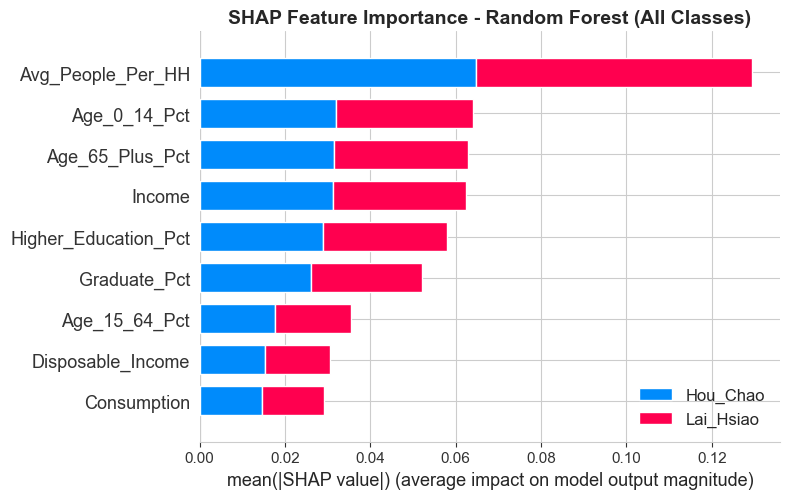

In [8]:
# Summary plot for all classes
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X, plot_type="bar", show=False, class_names=rf_model.classes_)
plt.title('SHAP Feature Importance - Random Forest (All Classes)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/shap_importance_rf_all.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Summary Plot - Lai-Hsiao

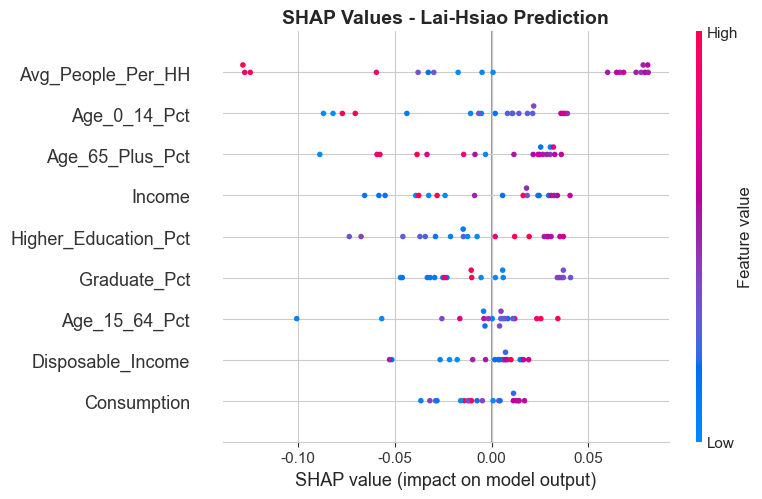


Interpretation:
- Each dot represents one district
- Red = high feature value, Blue = low feature value
- Positive SHAP = increases probability of Lai-Hsiao winning
- Negative SHAP = decreases probability of Lai-Hsiao winning


In [9]:
# Find Lai-Hsiao class index
lai_hsiao_idx = np.where(rf_model.classes_ == 'Lai_Hsiao')[0][0]

# Summary plot for Lai-Hsiao
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf[lai_hsiao_idx], X, show=False)
plt.title('SHAP Values - Lai-Hsiao Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/shap_summary_lai_hsiao.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Each dot represents one district")
print("- Red = high feature value, Blue = low feature value")
print("- Positive SHAP = increases probability of Lai-Hsiao winning")
print("- Negative SHAP = decreases probability of Lai-Hsiao winning")

### 2.4 Dependence Plot - Age Structure

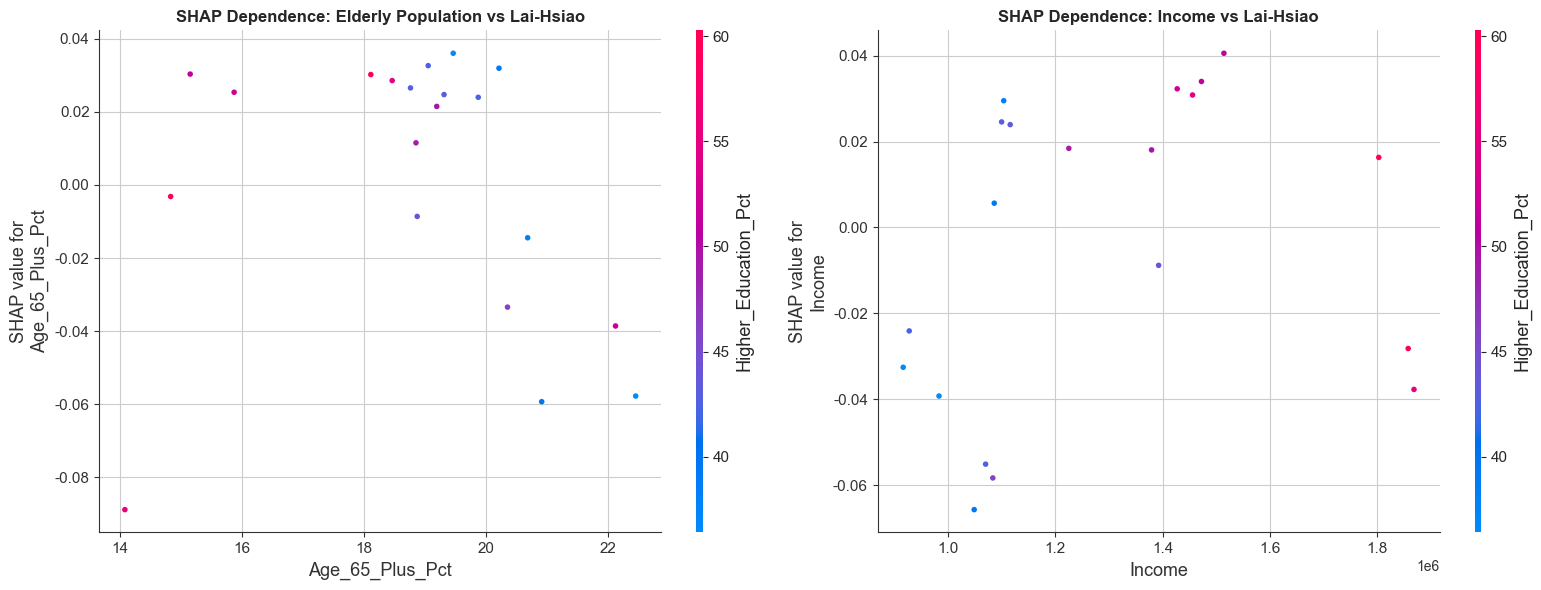

In [10]:
# Dependence plot for elderly population
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elderly population
shap.dependence_plot(
    'Age_65_Plus_Pct',
    shap_values_rf[lai_hsiao_idx],
    X,
    interaction_index='Higher_Education_Pct',
    ax=axes[0],
    show=False
)
axes[0].set_title('SHAP Dependence: Elderly Population vs Lai-Hsiao', fontsize=12, fontweight='bold')

# Income
shap.dependence_plot(
    'Income',
    shap_values_rf[lai_hsiao_idx],
    X,
    interaction_index='Higher_Education_Pct',
    ax=axes[1],
    show=False
)
axes[1].set_title('SHAP Dependence: Income vs Lai-Hsiao', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.5 Force Plot - Individual Predictions


District: Taipei City
Actual Winner: Lai_Hsiao


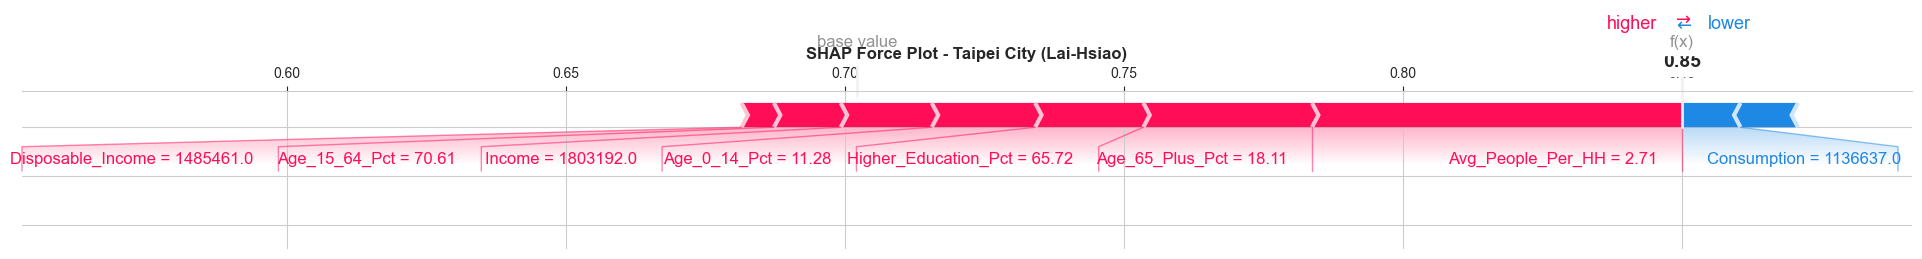


District: Tainan City
Actual Winner: Lai_Hsiao


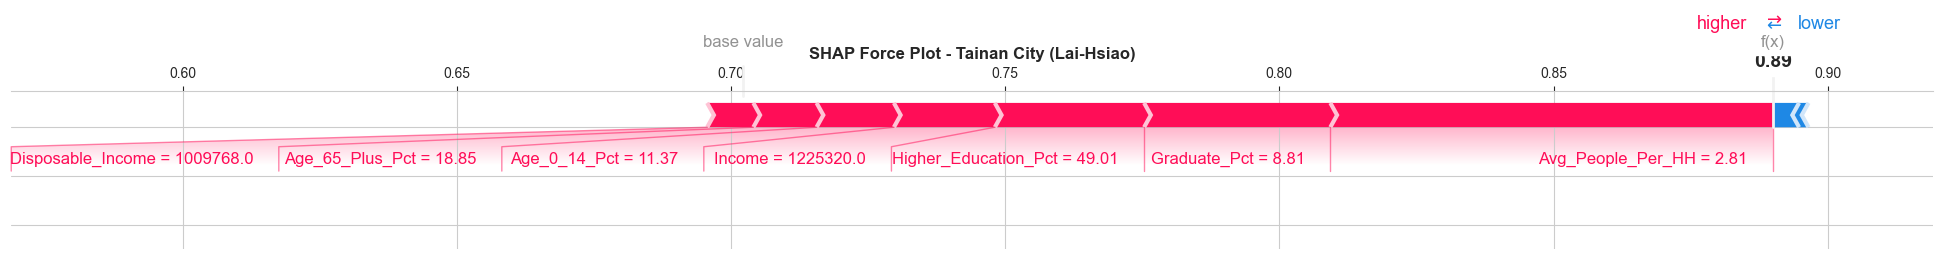


District: Hsinchu County
Actual Winner: Hou_Chao


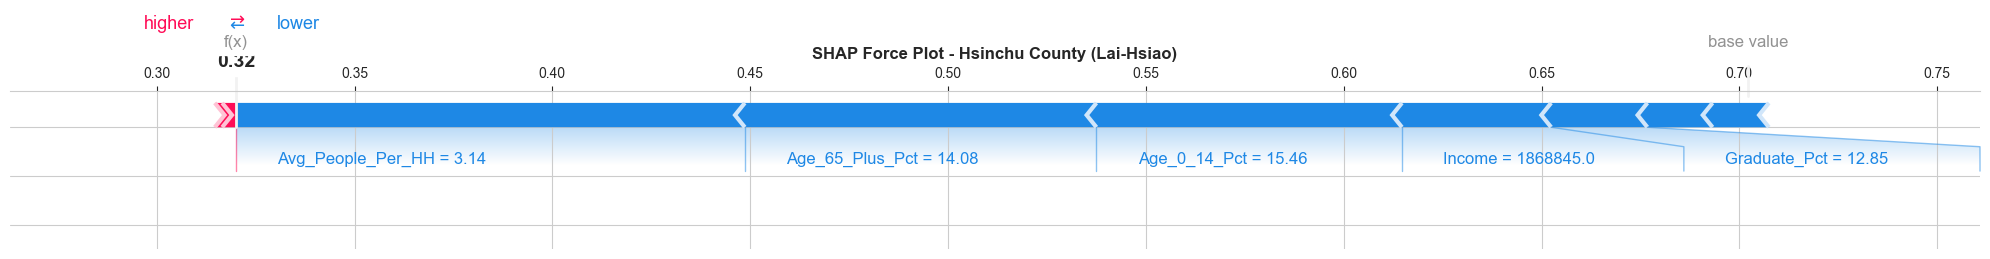

In [ ]:
# Select districts for explanation
districts = ['Taipei City', 'Tainan City', 'Hsinchu County']

for district_name in districts:
    idx = df[df['District'] == district_name].index[0]
    actual_winner = df.loc[idx, 'Winner']
    
    print(f"\n{'='*60}")
    print(f"District: {district_name}")
    print(f"Actual Winner: {actual_winner}")
    print(f"{'='*60}")
    
    # Force plot
    shap.force_plot(
        explainer_rf.expected_value[lai_hsiao_idx],
        shap_values_rf[lai_hsiao_idx][idx],
        X.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title(f'SHAP Force Plot - {district_name} (Lai-Hsiao)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../results/figures/shap_force_{district_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

## 3. SHAP Analysis - XGBoost

In [13]:
# Create SHAP explainer for XGBoost
print("Calculating SHAP values for XGBoost...")
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X)

print("SHAP values calculated!")

Calculating SHAP values for XGBoost...
SHAP values calculated!


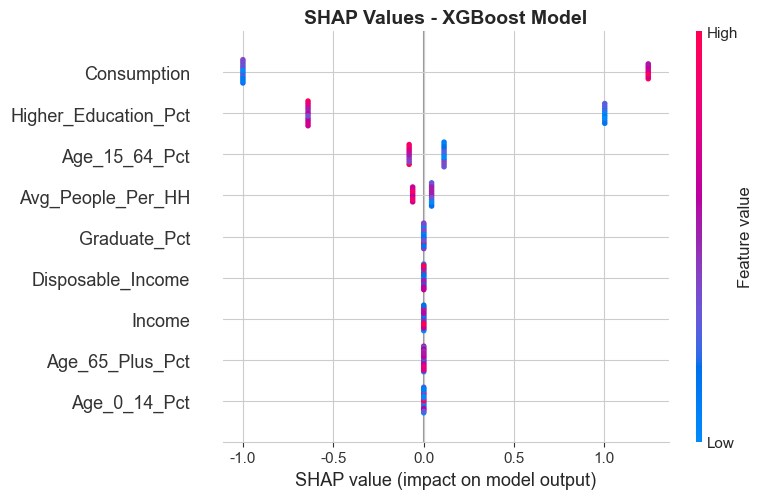

In [14]:
# Summary plot for XGBoost
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_xgb, X, show=False)
plt.title('SHAP Values - XGBoost Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/shap_summary_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Feature Interaction Analysis

Calculating SHAP interaction values...


<Figure size 1200x2000 with 0 Axes>

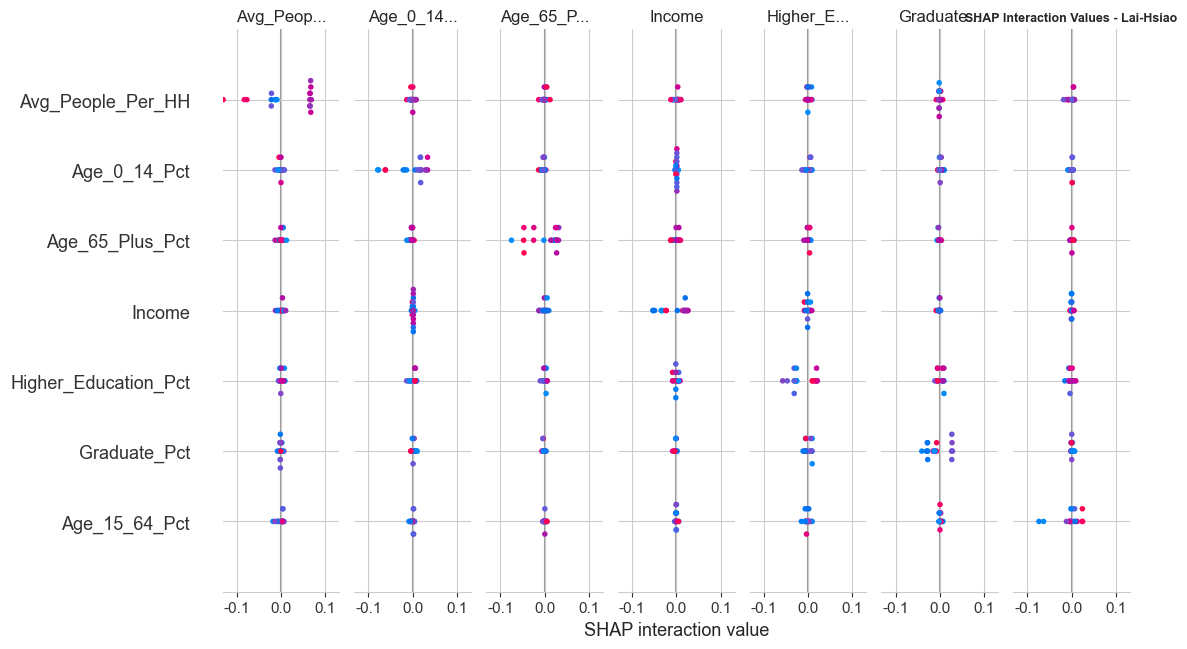

Interaction analysis complete!


In [25]:
# Calculate SHAP interaction values (this may take a moment)
print("Calculating SHAP interaction values...")
shap_interaction_values = explainer_rf.shap_interaction_values(X)

# Plot interaction for Lai-Hsiao class
plt.figure(figsize=(12, 20))
shap.summary_plot(
    shap_interaction_values[lai_hsiao_idx],
    X,
    show=False
)
plt.title('SHAP Interaction Values - Lai-Hsiao', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/shap_interactions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Interaction analysis complete!")

## 5. Waterfall Plot - Top 3 Districts

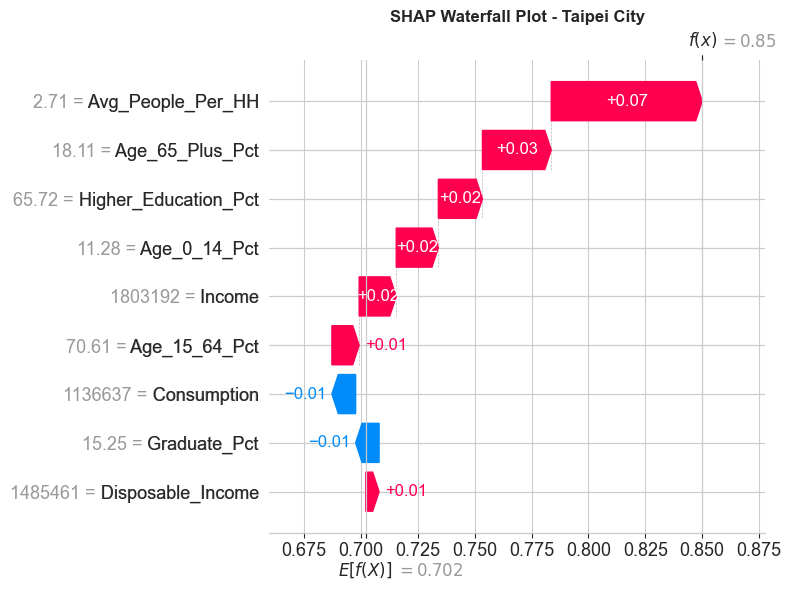

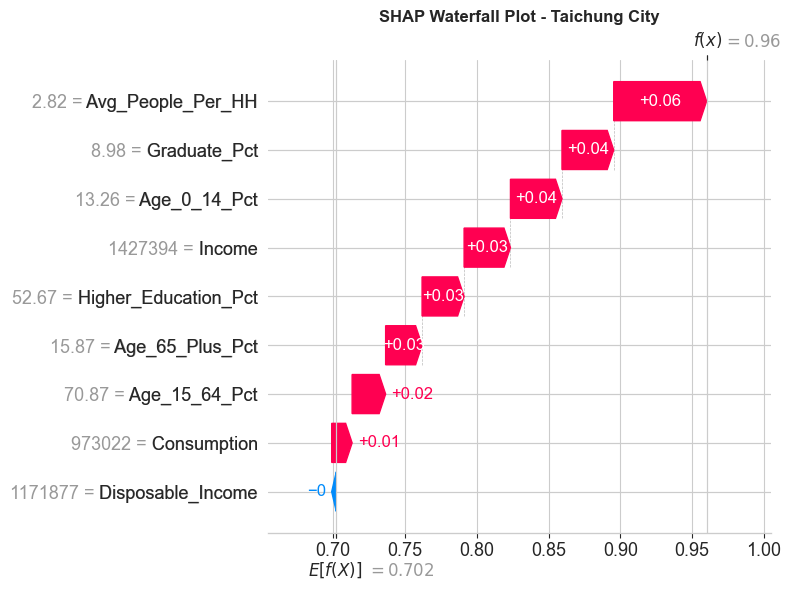

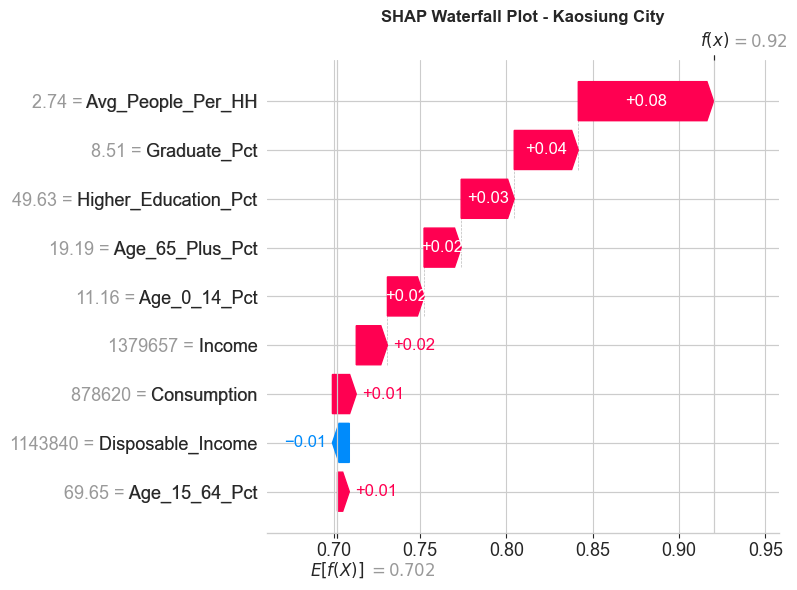

In [26]:
# Select top 3 districts by population
top_districts = df.nlargest(3, 'Total_Population')['District'].values

for district_name in top_districts:
    idx = df[df['District'] == district_name].index[0]
    
    # Create waterfall plot
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_rf[lai_hsiao_idx][idx],
            base_values=explainer_rf.expected_value[lai_hsiao_idx],
            data=X.iloc[idx],
            feature_names=feature_cols
        ),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - {district_name}', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../results/figures/shap_waterfall_{district_name.replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

## 6. Global Feature Importance Comparison

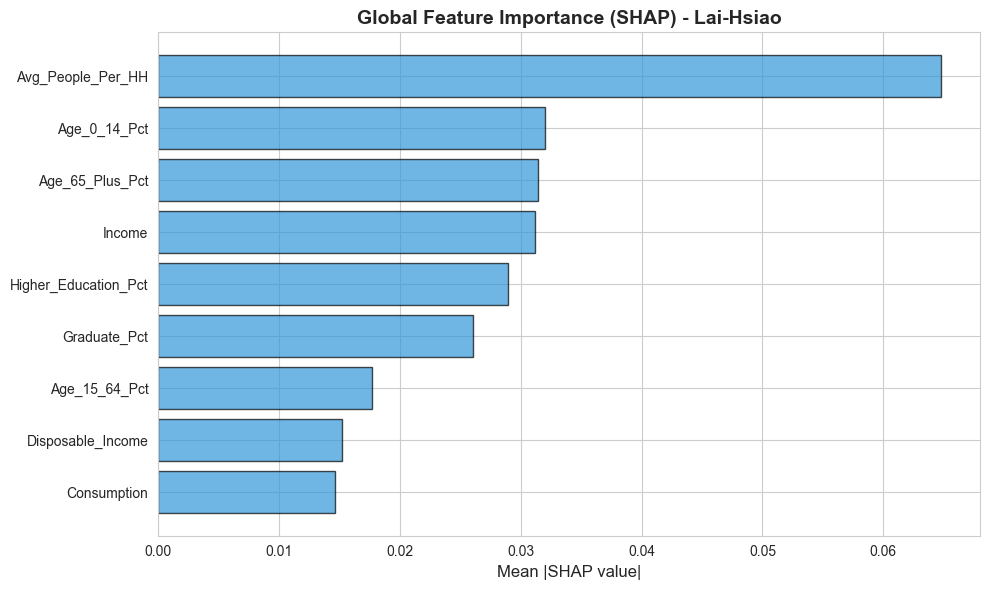


Top 5 Most Important Features (by SHAP):
             Feature  SHAP_Importance
   Avg_People_Per_HH         0.064759
        Age_0_14_Pct         0.032036
     Age_65_Plus_Pct         0.031384
              Income         0.031191
Higher_Education_Pct         0.028970


In [27]:
# Calculate mean absolute SHAP values for global importance
shap_importance_rf = np.abs(shap_values_rf[lai_hsiao_idx]).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'SHAP_Importance': shap_importance_rf
}).sort_values('SHAP_Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(shap_importance_df['Feature'], shap_importance_df['SHAP_Importance'],
         color='#3498db', alpha=0.7, edgecolor='black')
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.title('Global Feature Importance (SHAP) - Lai-Hsiao', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/shap_global_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 Most Important Features (by SHAP):")
print(shap_importance_df.head().to_string(index=False))

## 7. Key Insights from SHAP Analysis

In [29]:
print("\n" + "="*60)
print("KEY INSIGHTS FROM SHAP ANALYSIS")
print("="*60)

print("\n[1] Most Influential Features (Lai-Hsiao):")
for idx, row in shap_importance_df.head(3).iterrows():
    print(f" {row['Feature']}: {row['SHAP_Importance']:.4f}")

print("\n[2] Feature Directionality:")
# Analyze positive/negative correlations
for feature in shap_importance_df.head(3)['Feature']:
    feat_idx = feature_cols.index(feature)
    shap_vals = shap_values_rf[lai_hsiao_idx][:, feat_idx]
    feat_vals = X[feature].values
    
    correlation = np.corrcoef(feat_vals, shap_vals)[0, 1]
    direction = "increases" if correlation > 0 else "decreases"
    
    print(f"Higher {feature} {direction} Lai-Hsiao probability")

print("\n" + "="*60)


KEY INSIGHTS FROM SHAP ANALYSIS

[1] Most Influential Features (Lai-Hsiao):
 Avg_People_Per_HH: 0.0648
 Age_0_14_Pct: 0.0320
 Age_65_Plus_Pct: 0.0314

[2] Feature Directionality:
Higher Avg_People_Per_HH decreases Lai-Hsiao probability
Higher Age_0_14_Pct increases Lai-Hsiao probability
Higher Age_65_Plus_Pct decreases Lai-Hsiao probability



## 8. Export SHAP Values for Further Analysis

In [ ]:
# Create DataFrame with SHAP values
shap_df = pd.DataFrame(
    shap_values_rf[lai_hsiao_idx],
    columns=[f'SHAP_{col}' for col in feature_cols]
)
shap_df['District'] = districts.values
shap_df['Actual_Winner'] = y.values

# Save to CSV
shap_df.to_csv('../results/shap_values.csv', index=False)
print("SHAP values exported to: results/shap_values.csv")

# Display sample
print("\nSample SHAP values:")
print(shap_df.head())